In [8]:
from math import pi
import numpy as np
import scipy
import math
import random
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, assemble, Aer
from qiskit.primitives import Estimator
from qiskit.circuit import Gate
from math import pi
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms import VQE, NumPyEigensolver
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.utils import *
import qiskit.quantum_info as qi
import numpy as np
from qiskit.quantum_info import SparsePauliOp

import time

#from qiskit import execute
#from qiskit.visualization import array_to_latex
#from qiskit.opflow import I, X, Z
#from qiskit.quantum_info import Statevector
#from qiskit.quantum_info.operators import Operator


import qiskit.tools.jupyter
%qiskit_version_table

In [9]:
qubits=8

<h2>Parámetros de las Rotaciones Locales </h2>
<h3>Definición de las $\lambda$</h3>

Dado un qubit arbitrario, partimos de una rotación local:
$$
U = \exp\left(-\frac{i}{2} \tau \left(\hat{n} \cdot \vec{\sigma}\right)\right)
$$
Donde vamos a emplear coordenadas polares tal que: $\hat{n}=(sen(\theta)cos(\varphi),sen(\theta)sen(\varphi),cos(\theta))$

Por tanto, para un qubit dado, tenemos 3 parámetros: $\tau, \theta, \varphi$. El primero de estos es el thrust de la rotación, $\tau\in[0,\pi)$, y los dos restantes fijan la dirección del eje de giro, $\theta\in[0,\pi)$ y $\varphi\in[0,2\pi)$.


Nótese que el efecto de dicha rotación sobre una matriz de Pauli va a ser transformarla en una combinación lineal de matrices de Pauli. Esto es coherente pues al rotar los ejes, la matriz de Pauli que originalmente estaba definida en un eje se ve rotada.

Por tanto, definimos los parámetros $\lambda$ como:
$$
U^{\dagger}\sigma_{\alpha}U=\sum_{\beta=X,Y,Z} \lambda^{\alpha\beta}\sigma_{\beta}
$$

Donde hemos obviado el subíndice debido al número de qubit: $\lambda^{\alpha\beta}\equiv\lambda^{\alpha\beta}_{n}$

<h2>Valor esperado de las matrices de Pauli </h2>
<h3>Cálculo clásico de $\langle\sigma^{\alpha}_{n}\rangle$ y $\langle\sigma^{z}_{n}\sigma^{z}_{m}\rangle$ con el Ansatz:
$|\psi\rangle=U(y)V(M)U(x)|0\rangle\equiv U(y)V(M)|\phi(x)\rangle$</h3>

Recordamos que el Ansatz empleado está compuesto por las siguientes matrices:
$$
U = \exp(-\frac{i}{2} \tau \left(\hat{n} \cdot \vec{\sigma}\right))
$$
$$
V= \exp(-\frac{i}{4}\sum_{n\neq m}M_{nm}\sigma^{z}_{n}\sigma^{z}_{m})
$$

Además, destacamos que usamos el siguiente convenio para las matrices de Pauli:
$$
\sigma^{+}=\begin{pmatrix}0 & 1\\ 0 & 0\end{pmatrix}
$$

$$
\sigma^{-}=\begin{pmatrix}0 & 0\\ 1 & 0\end{pmatrix}
$$
Vamos a hallar $\langle\sigma^{\alpha}_{n}\rangle$.
$$
\langle\sigma^{\alpha}_{n}\rangle=\langle\phi(x)|V^{\dagger}U^{\dagger}\sigma^{\alpha}_{n}U V|\phi(x)\rangle
$$

Vamos a hallar $\langle\sigma^{z}_{n}\sigma^{z}_{m}\rangle$.
$$
\langle\sigma^{z}_{n}\sigma^{z}_{m}\rangle=\langle\phi(x)|V^{\dagger}U^{\dagger}\sigma^{z}_{n}\sigma^{z}_{m}U V|\phi(x)\rangle
$$

In [10]:
#-----------FUNCTIONS--------------
def lam(α,β,x): #α,β=x,y,z ; x[0]->Tau ; x[1]->Theta ; x[2]->Phi // x has 3 components
    out=0
    if(α==0 and β==0):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.sin(x[1])*np.sin(x[1])*np.cos(x[2])*np.cos(x[2])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    if(α==0 and β==1):
        out=2*np.sin(x[0]/2.0)*(np.sin(x[0]/2.0)*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.cos(x[2])-np.cos(x[0]/2.0)*np.cos(x[1]))
    if(α==0 and β==2):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.cos(x[2])+np.cos(x[0]/2.0)*np.sin(x[2]))
    if(α==1 and β==0):
        out=2*np.sin(x[0]/2.0)*(np.sin(x[0]/2.0)*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.cos(x[2])+np.cos(x[0]/2.0)*np.cos(x[1]))
    if(α==1 and β==1):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.sin(x[2])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    if(α==1 and β==2):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.sin(x[2])-np.cos(x[0]/2.0)*np.cos(x[2]))
    if(α==2 and β==0):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.cos(x[2])-np.cos(x[0]/2.0)*np.sin(x[2]))
    if(α==2 and β==1):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.sin(x[2])+np.cos(x[0]/2.0)*np.cos(x[2]))
    if(α==2 and β==2):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.cos(x[1])*np.cos(x[1])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    return(out)

def X(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_X=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_X+=np.real(s)*(lam(0,0,y[n])*lam(0,2,x[n])+lam(0,1,y[n])*lam(1,2,x[n]))
    E_X+=np.imag(s)*(lam(0,0,y[n])*lam(1,2,x[n])-lam(0,1,y[n])*lam(0,2,x[n]))
    E_X+=lam(0,2,y[n])*lam(2,2,x[n])
    return(E_X)

def Y(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_Y=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_Y+=np.real(s)*(lam(1,0,y[n])*lam(0,2,x[n])+lam(1,1,y[n])*lam(1,2,x[n]))
    E_Y+=np.imag(s)*(lam(1,0,y[n])*lam(1,2,x[n])-lam(1,1,y[n])*lam(0,2,x[n]))
    E_Y+=lam(1,2,y[n])*lam(2,2,x[n])
    return(E_Y)

def Z(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_Z=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_Z+=np.real(s)*(lam(2,0,y[n])*lam(0,2,x[n])+lam(2,1,y[n])*lam(1,2,x[n]))
    E_Z+=np.imag(s)*(lam(2,0,y[n])*lam(1,2,x[n])-lam(2,1,y[n])*lam(0,2,x[n]))
    E_Z+=lam(2,2,y[n])*lam(2,2,x[n])
    return(E_Z)

def ZZ(n, m, x, y, M): #n & m ->qubit, x & y & M -> parameters
    E_ZZ=0
    z=1
    v=1
    p=1
    t=1
    for i in range(0,qubits): #IMPORTANT: IS IT A 2 OR 4??????
        if(i!=n and i!=m):
            z*=(+1j*np.sin((M[n][i]+M[m][i])/2.0)*lam(2,2,x[i])+np.cos((M[n][i]+M[m][i])/2.0))
            v*=(+1j*np.sin((M[n][i]-M[m][i])/2.0)*lam(2,2,x[i])+np.cos((M[n][i]-M[m][i])/2.0))
            p*=(1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0))
            t*=(1j*np.sin(M[m][i]/2.0)*lam(2,2,x[i])+np.cos(M[m][i]/2.0))
    p*=(1j*np.sin(M[n][m]/2.0)+np.cos(M[n][m]/2.0)*lam(2,2,x[m]))
    t*=(1j*np.sin(M[m][n]/2.0)+np.cos(M[m][n]/2.0)*lam(2,2,x[n]))
    
    E_ZZ+=(np.real(z)/2.0)*(lam(2,0,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                           lam(2,0,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))-
                           lam(2,1,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.imag(z)/2.0)*(-lam(2,0,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))+
                            lam(2,0,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.real(v)/2.0)*(lam(2,0,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))-
                           lam(2,0,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.imag(v)/2.0)*(-lam(2,0,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))-
                            lam(2,0,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))-
                            lam(2,1,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=np.real(p)*(lam(2,0,y[n])*lam(2,2,y[m])*lam(0,2,x[n])+
                      lam(2,1,y[n])*lam(2,2,y[m])*lam(1,2,x[n])
                     )
    E_ZZ+=np.imag(p)*(-lam(2,0,y[n])*lam(2,2,y[m])*lam(1,2,x[n])+
                       lam(2,1,y[n])*lam(2,2,y[m])*lam(0,2,x[n])
                     )
    E_ZZ+=np.real(t)*(lam(2,2,y[n])*lam(2,0,y[m])*lam(0,2,x[m])+
                      lam(2,2,y[n])*lam(2,1,y[m])*lam(1,2,x[m])
                     )
    E_ZZ+=np.imag(t)*(-lam(2,2,y[n])*lam(2,0,y[m])*lam(1,2,x[m])+
                       lam(2,2,y[n])*lam(2,1,y[m])*lam(0,2,x[m])
                     )
    E_ZZ+=lam(2,2,y[n])*lam(2,2,y[m])*lam(2,2,x[n])*lam(2,2,x[m])
    return(E_ZZ) 

<h2>Hamiltoniano Long-Range </h2>
<h3>Definición de LRH</h3>
El Hamiltoniano long-range a simular es :
$$
H = \sum_{ij}{J_{ij}\sigma^{z}_{i}\sigma^{z}_{j}}+h_{x}\sum_{i}{\sigma^{x}_{i}}+\epsilon\sum_{i}{\sigma^{z}_{i}}
$$
Las $J_{ij}$ se normalizan,
$$
J_{ij}=\frac{\tilde{J_{ij}}}{\tilde{N}}
$$
donde decaen si i=j así:
$$
\tilde{J_{ij}}=J\cdot b 
$$
mientras que si $i\neq j$, lo hacen de la siguiente manera:
$$
\tilde{J_{ij}}=J\cdot |i-j|^{-\alpha} 
$$
Finalmente, la normalización viene dada por:
$$
\tilde{N}=\sum_{j}{\tilde{J_{ij}}}
$$
donde usamos P.B.C, de forma que $i$ es arbitrario.

In [11]:
#--------------HAMILTONIAN----------------------
def LRH_cl(t, J, eps, h, alpha): 
    #Parameters of Ansatze
    x=np.zeros((qubits,3))
    y=np.zeros((qubits,3))
    M=np.zeros((qubits,qubits))
    for i in range(0,qubits):
        x[i]=t[0+3*i:3+3*i]
        y[i]=t[3*qubits+0+3*i:3*qubits+3+3*i]
    p=6*qubits
    for i in range(0,qubits-1):
        k=0
        for j in range(i+1,qubits):
            M[i][j]=t[k+p]
            M[j][i]=t[k+p]
            k+=1
        p+=k    
        
    b=1 #This is fixed b=1
    J_bar=0
    N_bar=1
    J_ham=0
    dist=0
    for j in range (1,qubits):
        dist = min(abs(j), qubits - abs(j))
        N_bar+=float(1/dist)**alpha #Normalization    
    E=0
    for i in range(0,qubits):
        for j in range(0,qubits):
            if(i==j):
                J_bar=J*b
                J_ham=float(J_bar/N_bar)
                E+=J_ham
            else:
                dist=min(abs(i - j), qubits - abs(i - j))
                J_bar=J*dist**(-alpha)
                J_ham=float(J_bar/N_bar)
                E+=J_ham*ZZ(i,j,x,y,M)
    for i in range(0,qubits):
        E+=h*X(i,x,y,M)
        E+=eps*Z(i,x,y,M)
    return (E)  

def LRH_Matrix(J, eps, h, alpha): #Capital Letters correspond to inputs (Intensity of the Fields)
    b=1 #This is fixed b=1
    J_bar=0
    N_bar=1
    J_ham=0
    dist=0
    for j in range (1,qubits):
        dist = min(abs(j), qubits - abs(j))
        N_bar+=float(1/dist)**alpha #Normalization
        
    ZZ_tuples=[]
    for i in range(0,qubits):
        for j in range(0,qubits):
            if(i==j):
                J_bar=J*b
                J_ham=float(J_bar/N_bar)
                ZZ_tuples.append(('I', [i], J_ham)) #ZZ in the same qubit is the identity
            else:
                dist=min(abs(i - j), qubits - abs(i - j))
                J_bar=J*(dist**(-alpha))
                J_ham=float(J_bar/N_bar)
                ZZ_tuples.append(('ZZ', [i,j], J_ham)) #Coupling      
                         
    X_tuples = [('X', [i], h) for i in range(0, qubits)] #Uniform Transverse Field
    Z_tuples = [('Z', [i], eps) for i in range(0, qubits)] #Longitudinal Field

    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples, *Z_tuples], num_qubits = qubits)
    return hamiltonian.simplify()

#----------- PARAMETERS (THETA)-------------
initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
          np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*qubits
dimM=int(qubits*(qubits-1)/2)
initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM

initialParam=initialθ+initialM
starting_point=[0]*len(initialParam)

boundsθ=[[0, np.pi], [0, np.pi], [0, 2*np.pi],
         [0, np.pi], [0, np.pi], [0, 2*np.pi]]*qubits
boundsM=[[0,2*np.pi]]*dimM
bounds=boundsθ+boundsM

inter_param=[]
inter_fun=[]
def save_step(k):
    inter_param.append(k)
    inter_fun.append(LRH_cl(k, J, eps, h, alpha))
    
counts = []
values = []
param = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    param.append(parameters)

<h2>Circuito Cuántico </h2>
El siguiente circuito describe el estado (Ansatz):
$|\psi\rangle=U(y)V(M)U(x)|0\rangle\equiv U(y)V(M)|\phi(x)\rangle$

In [12]:
class U_xyz_Gate(Gate):
    def __init__(
        self,
        tau,
        theta,
        phi,
        q,
        label=None,
        *,
        duration=None,
        unit="dt",
        
    ):
        super().__init__('U', 1, [tau,theta,phi], label=label)

    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [self.q])
        self.definition = qc
    
    def __array__(self, dtype=complex):
        """Return a numpy.array for the U_xyz gate."""
        tau, theta, phi = (float(param) for param in self.params)
        
        return np.array([[np.cos(tau/2)-1j*np.sin(tau/2)*np.cos(theta), -1j*np.sin(tau/2)*np.sin(theta)*np.exp(-1j*phi) ], 
                         [ -1j*np.sin(tau/2)*np.sin(theta)*np.exp(1j*phi) , np.cos(tau/2)+1j*np.sin(tau/2)*np.cos(theta)]]
                         , dtype=dtype)

def GsCircuit(layers, t): #Nº of parameters needed is 6N+N(N-1)/2
    qc = QuantumCircuit(qubits)
    dimM_layer=int(qubits*(qubits-1)/2)
    dimθ_layer=6*qubits
    dim_layer=dimM_layer+dimθ_layer
    for layer in range (0, layers, 1):
        #---------- This is U(x)
        for i in range (0,qubits):
            U_x = U_xyz_Gate(t[0+3*i+dim_layer*layer],t[0+3*i+1+dim_layer*layer],t[0+3*i+2+dim_layer*layer],i,label='U_xyz')
            qc.append(U_x, [i])
        #---------- This is V(M)
        p=6*qubits
        for i in range(0,qubits-1):
            k=0
            for j in range(i+1,qubits):
                qc.cx(i,j)
                qc.rz(t[k+p+dim_layer*layer]/2.0,j)
                qc.cx(i,j)
                k+=1
            p+=k 
        #---------- This is U(y)
        for i in range (0,qubits):
            U_y = U_xyz_Gate(t[3*qubits+0+3*i+dim_layer*layer],t[3*qubits+0+3*i+1+dim_layer*layer],t[3*qubits+0+3*i+2+dim_layer*layer],i,label='U_xyz')
            qc.append(U_y, [i])
        qc.barrier()
    return qc

def InitializeParameters (layers): 
    dimM=int(qubits*(qubits-1)/2)*layers
    dimθ=6*qubits*layers
    s=qubits*layers
    dimt=dimM+dimθ
    
    initialθ=[0]*dimθ
    initialM=[0]*dimM
    initialParam=[0]*dimt
    
    initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
              np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*s
    initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM
    initialParam=initialθ+initialM
    
    return (initialParam)

def GroundStates(layers, J, h, eps, alpha, qcircuit):
    
    #iterations = 300 #Maybe quitar esta condición al usar COBYLA?
    seed=170
    algorithm_globals.random_seed=seed

    estimator=Estimator()
    ansatz=qcircuit
    optimizer=SLSQP()

    initialθ=InitializeParameters (layers)
    
    Hami=LRH_Matrix(J, eps, h, alpha) #H is intensity of longitudinal field. Hami is hamiltonian
    vqe=VQE(estimator, ansatz, optimizer, initial_point=initialParam, callback=store_intermediate_result)
    result=vqe.compute_minimum_eigenvalue(Hami)

    return result.optimal_value
    #Function returns the VQE groundstate and the exact minimum and maximum

In [13]:
#------- PARAMATERS OF THE SIMULATION----------
#Range of J
J_Left=np.arange(-0.1, -4.1, -0.1)
J_Right=np.arange(0.1, 10.1, 0.1)
J_Middle=[0]    

#---PARAMETERS HAMILTONIAN---
eps=0.001 #Break degeneracy
h=-1 #h is transverse field, not hamiltonian.
alpha=0.5
#Store values
E_L1_Left=[0]*len(J_Left) #VQA 1 Layer
E_L1_Right=[0]*len(J_Right)
E_L2_Left=[0]*len(J_Left) #VQA 2 Layer
E_L2_Right=[0]*len(J_Right)
E_L1_Middle=[0]
E_L2_Middle=[0]
E_cl_Left=[0]*len(J_Left) #Classical
E_cl_Right=[0]*len(J_Right)
ED_Left=[0]*len(J_Left) #Ground State
ED_Right=[0]*len(J_Right)
ED2_Left=[0]*len(J_Left) #First Excitation Energy
ED2_Right=[0]*len(J_Right)
E_cl_Middle=[0]
ED_Middle=[0]
ED2_Middle=[0]

In [14]:
#----------VQE LAYER 1-----------
layers=1
    
dimM=int(qubits*(qubits-1)/2)*layers
dimθ=6*qubits*layers
dimt=dimM+dimθ
initialParam=InitializeParameters(layers)
starting_point=[0]*len(initialParam)
t=ParameterVector('θ', length=dimt)
qc=GsCircuit(layers, t)
#-----MIDDLE POINT------
J=0.0
Hami=LRH_Matrix(J, eps, h, alpha)
ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
result_sim=GroundStates(layers, J, h, eps, alpha, qc)

err_rel=0
result_exact=ED[0]
err_rel=abs((result_sim-result_exact)*100/result_exact)
    
ED_Middle[0]=result_exact
E_L1_Middle[0]=result_sim
ED2_Middle[0]=ED[1]
print('--------- VALOR DE J:'+str(J))
print('El valor VQA es:')
print(result_sim)
print('El valor ED es:')
print(result_exact)
print('El error relativo es:')
print(err_rel)

starting_point=param[-1]
#-----------ED-----------
for i, J in enumerate(J_Left): 
    Hami=LRH_Matrix(J, eps, h, alpha)
    ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
    ED_Left[i]=ED[0] #Ground State
    ED2_Left[i]=ED[1] #1st Energy
    
for i, J in enumerate(J_Right):
    Hami=LRH_Matrix(J, eps, h, alpha)
    ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
    ED_Right[i]=ED[0] #Ground State
    ED2_Right[i]=ED[1] #1st Energy
#-----------VQA---------
start = time.time()    
initialParam=starting_point
for i, J in enumerate(J_Left):
    result_sim=GroundStates(layers, J, h, eps, alpha, qc)
    initialParam=param[-1]
    E_L1_Left[i]=result_sim #VQE Ground State Energy
    
initialParam=starting_point
for i, J in enumerate(J_Right):
    result_sim=GroundStates(layers, J, h, eps, alpha, qc)
    initialParam=param[-1]
    E_L1_Right[i]=result_sim #VQE Ground State Energy
end = time.time()
print(f"El codigo con ha tardado: {end-start} seconds, usando layers: "+str(layers))

--------- VALOR DE J:0.0
El valor VQA es:
-8.000003962951858
El valor ED es:
-8.000003999999002
El error relativo es:
4.6308906869549505e-07
El codigo con ha tardado: 3302.091143846512 seconds, usando layers: 1


In [15]:
#----------VQE LAYER 2------
layers=2
    
dimM=int(qubits*(qubits-1)/2)*layers
dimθ=6*qubits*layers
dimt=dimM+dimθ
initialParam=InitializeParameters (layers)
t=ParameterVector('θ', length=dimt)
qc=GsCircuit(layers, t)

#-----MIDDLE POINT------
J=0.0
Hami=LRH_Matrix(J, eps, h, alpha)
ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
result_sim=GroundStates(layers, J, h, eps, alpha, qc)

err_rel=0
result_exact=ED[0]
err_rel=abs((result_sim-result_exact)*100/result_exact)
    

E_L2_Middle[0]=result_sim
print('--------- VALOR DE J:'+str(J))
print('El valor VQA es:')
print(result_sim)
print('El valor ED es:')
print(result_exact)
print('El error relativo es:')
print(err_rel)

starting_point=param[-1]
#-----------VQA---------
start = time.time()    
initialParam=starting_point
for i, J in enumerate(J_Left):
    result_sim=GroundStates(layers, J, h, eps, alpha, qc)
    initialParam=param[-1]
    E_L2_Left[i]=result_sim #VQE Ground State Energy
    print('--------- VALOR DE J:'+str(J))
    print('El valor VQA es:'+str(E_L2_Left[i]))
    
initialParam=starting_point
for i, J in enumerate(J_Right):
    result_sim=GroundStates(layers, J, h, eps, alpha, qc)
    initialParam=param[-1]
    E_L2_Right[i]=result_sim #VQE Ground State Energy
    print('--------- VALOR DE J:'+str(J))
    print('El valor VQA es:'+str(E_L2_Right[i]))
    
end = time.time()
print(f"El codigo con ha tardado: {end-start} seconds, usando layers: "+str(layers))

--------- VALOR DE J:0.0
El valor VQA es:
-8.00000230128394
El valor ED es:
-8.000003999998997
El error relativo es:
2.1233927590781974e-05
--------- VALOR DE J:-0.1
El valor VQA es:-8.134006894868604
--------- VALOR DE J:-0.2
El valor VQA es:-8.279911327417354
--------- VALOR DE J:-0.30000000000000004
El valor VQA es:-8.437669286864917
--------- VALOR DE J:-0.4
El valor VQA es:-8.62091648792569
--------- VALOR DE J:-0.5
El valor VQA es:-8.821170330744572
--------- VALOR DE J:-0.6
El valor VQA es:-9.050226515511692
--------- VALOR DE J:-0.7000000000000001
El valor VQA es:-9.31490595450258
--------- VALOR DE J:-0.8
El valor VQA es:-9.645880330679333
--------- VALOR DE J:-0.9
El valor VQA es:-10.058053645787366
--------- VALOR DE J:-1.0
El valor VQA es:-10.528667843829641
--------- VALOR DE J:-1.1
El valor VQA es:-11.063505291102873
--------- VALOR DE J:-1.2000000000000002
El valor VQA es:-11.650646364646272
--------- VALOR DE J:-1.3000000000000003
El valor VQA es:-12.277648382266424
---

--------- VALOR DE J:8.4
El valor VQA es:-4.069000194881976
--------- VALOR DE J:8.5
El valor VQA es:-4.073812336991336
--------- VALOR DE J:8.6
El valor VQA es:-4.079534025682216
--------- VALOR DE J:8.7
El valor VQA es:-4.086203391809426
--------- VALOR DE J:8.8
El valor VQA es:-4.093667399447623
--------- VALOR DE J:8.9
El valor VQA es:-4.101930553175002
--------- VALOR DE J:9.0
El valor VQA es:-4.110928280633428
--------- VALOR DE J:9.1
El valor VQA es:-4.120871379904461
--------- VALOR DE J:9.2
El valor VQA es:-4.131370842823085
--------- VALOR DE J:9.3
El valor VQA es:-4.142569611103337
--------- VALOR DE J:9.4
El valor VQA es:-4.154369144020322
--------- VALOR DE J:9.5
El valor VQA es:-4.166950770394273
--------- VALOR DE J:9.6
El valor VQA es:-4.1800040365850935
--------- VALOR DE J:9.700000000000001
El valor VQA es:-4.193618109957591
--------- VALOR DE J:9.8
El valor VQA es:-4.207749418194512
--------- VALOR DE J:9.9
El valor VQA es:-4.222461022413578
--------- VALOR DE J:10.0

In [16]:
#-------CLASSICAL-------
initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
          np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*qubits
dimM=int(qubits*(qubits-1)/2)
initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM

initialParam=initialθ+initialM
starting_point=[0]*len(initialParam)

boundsθ=[[0, np.pi], [0, np.pi], [0, 2*np.pi],
         [0, np.pi], [0, np.pi], [0, 2*np.pi]]*qubits
boundsM=[[0,2*np.pi]]*dimM
bounds=boundsθ+boundsM
#-----MIDDLE POINT------
J=0.0
Hami=LRH_Matrix(J, eps, h, alpha)
ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
E_cl=scipy.optimize.minimize(LRH_cl, initialParam, args=(J, eps, h, alpha),
                                 callback=save_step, 
                                 bounds = bounds,
                                 method = 'SLSQP')
err_rel=0
result_exact=ED[0]
err_rel=abs((E_cl.fun-result_exact)*100/result_exact)
E_cl_Middle[0]=E_cl.fun
print('--------- VALOR DE J:'+str(J))
print('El valor clasico es:')
print(E_cl.fun)
print('El valor ED es:')
print(result_exact)
print('El error relativo es:')
print(err_rel)

starting_point=E_cl.x
#------LEFT TREE--------
start = time.time()   
initialParam=starting_point
for i, J in enumerate(J_Left): 
    E_cl=scipy.optimize.minimize(LRH_cl, initialParam, args=(J, eps, h, alpha),
                                 callback=save_step, 
                                 bounds = bounds,
                                 method = 'SLSQP')
    initialParam=E_cl.x #Using the last parameters as starting point for next iteration
    E_cl_Left[i]=E_cl.fun
    print('--------- VALOR DE J:'+str(J))
    print('El valor clásico es:'+str(E_cl_Left[i]))
    
#------RIGHT TREE--------
initialParam=starting_point
for i, J in enumerate(J_Right):
    E_cl=scipy.optimize.minimize(LRH_cl, initialParam, args=(J, eps, h, alpha),
                                 callback=save_step, 
                                 bounds = bounds,
                                 method = 'SLSQP')
    initialParam=E_cl.x #Using the last parameters as starting point for next iteration
    E_cl_Right[i]=E_cl.fun
    print('--------- VALOR DE J:'+str(J))
    print('El valor clásico es:'+str(E_cl_Right[i]))
    
end = time.time()
print(f"El codigo con ha tardado: {end-start} seconds, usando método CLÁSICO")

--------- VALOR DE J:0.0
El valor clasico es:
-8.000003452495902
El valor ED es:
-8.000003999998984
El error relativo es:
6.843785113990168e-06
--------- VALOR DE J:-0.1
El valor clásico es:-8.13245756795574
--------- VALOR DE J:-0.2
El valor clásico es:-8.266468625135532
--------- VALOR DE J:-0.30000000000000004
El valor clásico es:-8.401948239311277
--------- VALOR DE J:-0.4
El valor clásico es:-8.539041164738569
--------- VALOR DE J:-0.5
El valor clásico es:-8.6778419117525
--------- VALOR DE J:-0.6
El valor clásico es:-8.818650995459276
--------- VALOR DE J:-0.7000000000000001
El valor clásico es:-9.042683419748002
--------- VALOR DE J:-0.8
El valor clásico es:-9.410397655584177
--------- VALOR DE J:-0.9
El valor clásico es:-9.874904043636661
--------- VALOR DE J:-1.0
El valor clásico es:-10.407041699381626
--------- VALOR DE J:-1.1
El valor clásico es:-10.988130903956556
--------- VALOR DE J:-1.2000000000000002
El valor clásico es:-11.605881550333288
--------- VALOR DE J:-1.300000

--------- VALOR DE J:7.7
El valor clásico es:-3.972205099554168
--------- VALOR DE J:7.8
El valor clásico es:-3.9774770578933856
--------- VALOR DE J:7.9
El valor clásico es:-3.9838038984460122
--------- VALOR DE J:8.0
El valor clásico es:-3.9909000930377823
--------- VALOR DE J:8.1
El valor clásico es:-3.99882459279331
--------- VALOR DE J:8.2
El valor clásico es:-4.0075575284261475
--------- VALOR DE J:8.3
El valor clásico es:-4.017029462997525
--------- VALOR DE J:8.4
El valor clásico es:-4.027210323008594
--------- VALOR DE J:8.5
El valor clásico es:-4.0380832784572664
--------- VALOR DE J:8.6
El valor clásico es:-4.049734020394868
--------- VALOR DE J:8.7
El valor clásico es:-4.061895761311097
--------- VALOR DE J:8.8
El valor clásico es:-4.074637459028675
--------- VALOR DE J:8.9
El valor clásico es:-4.087958250449043
--------- VALOR DE J:9.0
El valor clásico es:-4.101800352446467
--------- VALOR DE J:9.1
El valor clásico es:-4.116180430574916
--------- VALOR DE J:9.2
El valor cl

In [17]:
dim_Plot=len(J_Left)+len(J_Right)+len(J_Middle)

J=[0]*dim_Plot
E_cl=[0]*dim_Plot
E_L1=[0]*dim_Plot
E_L2=[0]*dim_Plot
ED1=[0]*dim_Plot
ED2=[0]*dim_Plot
Error_cl=[0]*dim_Plot
Error_L1=[0]*dim_Plot
Error_L2=[0]*dim_Plot

#Note that the Left list has to be reversed.
J_Left=J_Left[::-1]
E_L1_Left=E_L1_Left[::-1]
E_L2_Left=E_L2_Left[::-1]
E_cl_Left=E_cl_Left[::-1]
ED_Left=ED_Left[::-1]
ED2_Left=ED2_Left[::-1]

J=np.concatenate((J_Left,J_Middle,J_Right))
E_cl=np.concatenate((E_cl_Left,E_cl_Middle,E_cl_Right))
E_L1=np.concatenate((E_L1_Left,E_L1_Middle,E_L1_Right))
E_L2=np.concatenate((E_L2_Left,E_L2_Middle,E_L2_Right))
ED1=np.concatenate((ED_Left,ED_Middle,ED_Right))
ED2=np.concatenate((ED2_Left,ED2_Middle,ED2_Right))

file_1=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\Energy_0.5_V2.txt','w')
file_2=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\Error_0.5_V2.txt','w')

file_1.write('#J E_L1 E_L2 E_cl ED_Ground ED_Exc\n') #CONTENTS OF FILE_1
file_2.write('#J Err_L1 Err_L2 E_cl\n') #CONTENTS OF FILE_1
for i in range(0,dim_Plot):
    Error_L1[i]=abs(E_L1[i]-ED1[i])*100/abs(ED1[i])
    Error_L2[i]=abs(E_L2[i]-ED1[i])*100/abs(ED1[i])
    Error_cl[i]=abs(E_cl[i]-ED1[i])*100/abs(ED1[i])
    file_1.write(str(J[i])+' '+str(E_L1[i])+' '+str(E_L2[i])+' '+str(E_cl[i])+' '+str(ED1[i])+' '+str(ED2[i])+'\n')
    file_2.write(str(J[i])+' '+str(Error_L1[i])+' '+str(Error_L2[i])+' '+str(Error_cl[i])+'\n')

file_1.close()
file_2.close()

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'retina'
plt.style.use('classic')
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['figure.facecolor'] = 'white'

#------EXTRACT DATA-------
data_1=np.loadtxt('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\Energy_0.5_V2.txt')
J_Plot=data_1[:,0]
E_L1_Plot=data_1[:,1]
E_L2_Plot=data_1[:,2]
E_cl_Plot=data_1[:,3]
ED1_Plot=data_1[:,4]
ED2_Plot=data_1[:,5]

data_2=np.loadtxt('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\Error_0.5_V2.txt')
Error_L1_Plot=data_2[:,1]
Error_L2_Plot=data_2[:,2]
Error_cl_Plot=data_2[:,3]

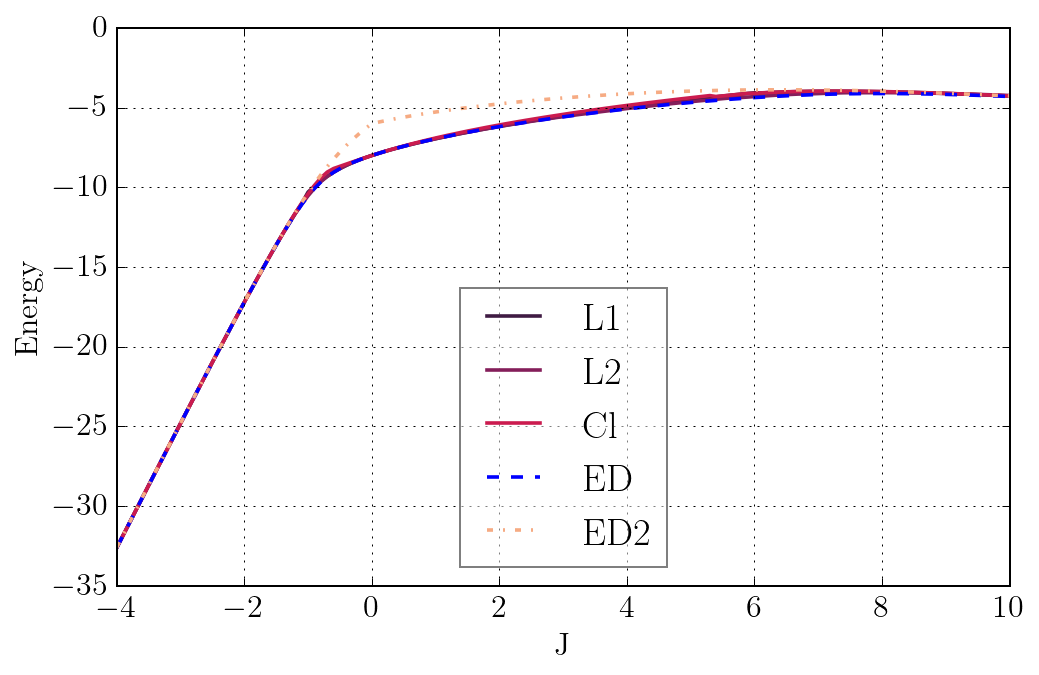

In [19]:
#-----PLOTS ENERGY-------
colors = sns.color_palette("rocket", 5)
plt.plot(J_Plot, E_L1_Plot, marker='', linestyle='-', color=colors[0], label='L1')
plt.plot(J_Plot, E_L2_Plot, marker='', linestyle='-', color=colors[1], label='L2')
plt.plot(J_Plot, E_cl_Plot, marker='', linestyle='-', color=colors[2], label='Cl')
plt.plot(J_Plot, ED1_Plot, marker='', linestyle='--', color='b', label='ED')
plt.plot(J_Plot, ED2_Plot, marker='', linestyle='-.', color=colors[4], label='ED2')

plt.xlabel('J')
plt.ylabel('Energy')
plt.grid(True)
plt.legend(loc='lower center', framealpha=0.5)
plt.show()

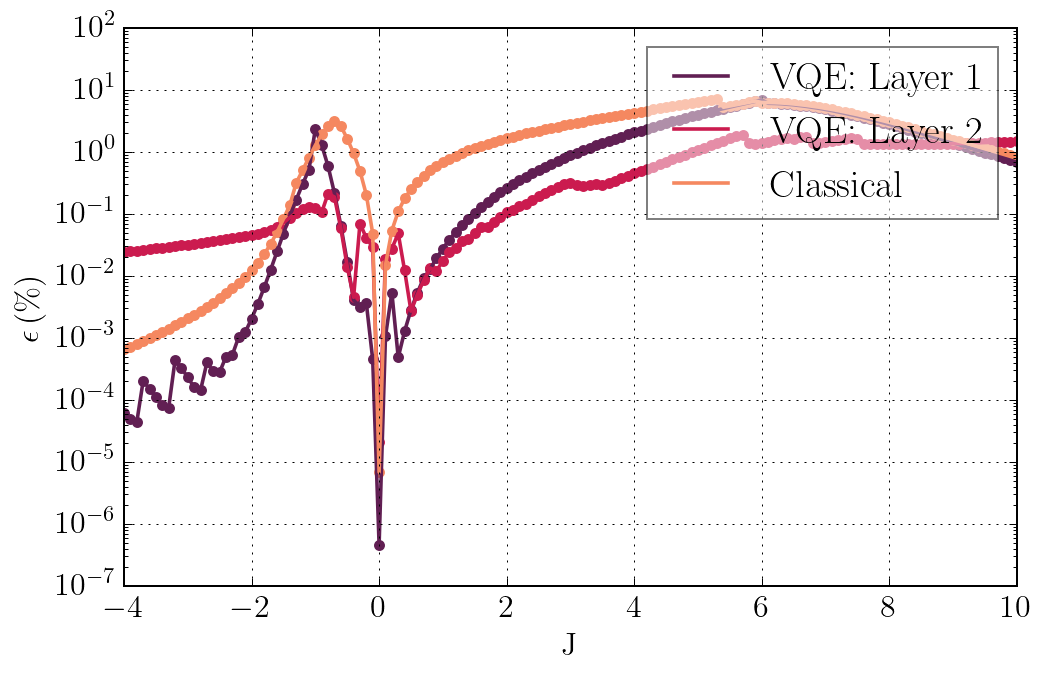

In [20]:
#-----PLOT ERROR-------
colors = sns.color_palette("rocket", 3)
plt.plot(J_Plot, Error_L1_Plot, marker='', linestyle='-', color=colors[0], label='VQE: Layer 1')
plt.plot(J_Plot, Error_L2_Plot, marker='', linestyle='-', color=colors[1], label='VQE: Layer 2')
plt.plot(J_Plot, Error_cl_Plot, marker='', linestyle='-', color=colors[2], label='Classical')

plt.scatter(J_Plot, Error_L1_Plot, marker='o', color=colors[0])
plt.scatter(J_Plot, Error_L2_Plot, marker='o', color=colors[1])
plt.scatter(J_Plot, Error_cl_Plot, marker='o', color=colors[2])
plt.xlabel('J')
plt.xlim(-4, 10)
plt.yscale('log')
plt.ylabel('$\epsilon\,(\%)$')
plt.grid(True)
plt.legend(loc='upper right')
plt.legend(framealpha=0.5)
plt.show()

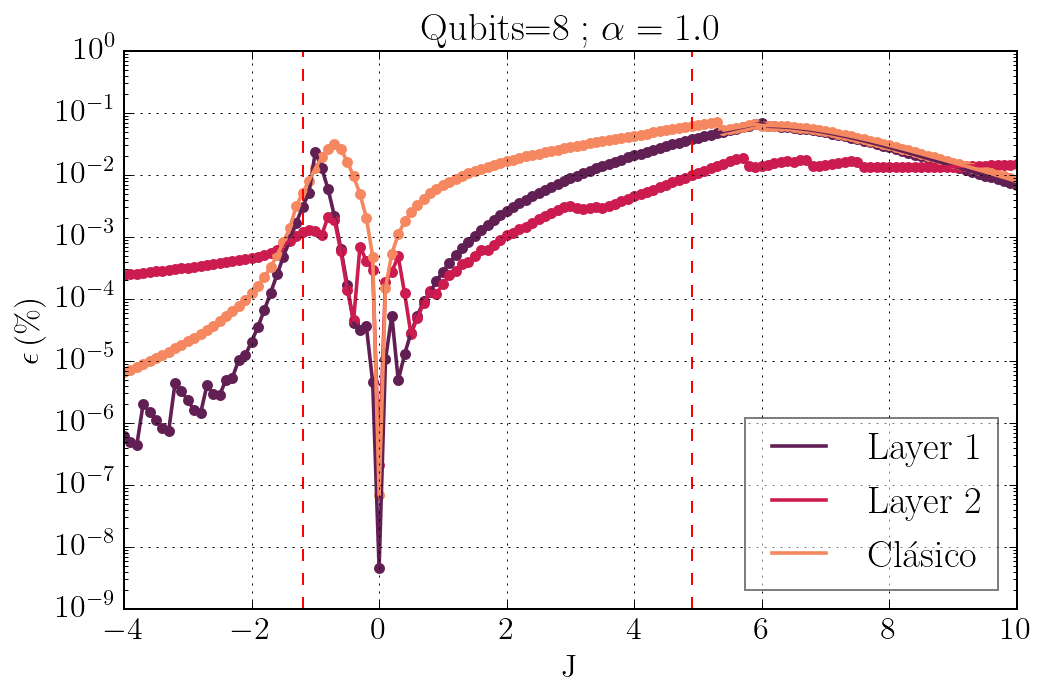

In [22]:
#-----PLOT ERROR-------
Error_L2=[0]*len(E_L2_Plot)
for i in range(len(E_L2_Plot)):
    Error_L2[i]=abs((E_L2_Plot[i]-ED1_Plot[i])/ED1_Plot[i])

Error_L1=[0]*len(E_L2_Plot)
for i in range(len(E_L1_Plot)):
    Error_L1[i]=abs((E_L1_Plot[i]-ED1_Plot[i])/ED1_Plot[i])
    
Error_cl=[0]*len(E_cl_Plot)
for i in range(len(E_L2_Plot)):
    Error_cl[i]=abs((E_cl_Plot[i]-ED1_Plot[i])/ED1_Plot[i])
    
colors = sns.color_palette("rocket", 3)
plt.plot(J_Plot, Error_L1, marker='', linestyle='-', color=colors[0], label='Layer 1')
plt.plot(J_Plot, Error_L2, marker='', linestyle='-', color=colors[1], label='Layer 2')
plt.plot(J_Plot, Error_cl, marker='', linestyle='-', color=colors[2], label='Clásico')

plt.axvline(x=J_Plot[28], color='red', linestyle='--', linewidth=1)
plt.axvline(x=J_Plot[89], color='red', linestyle='--', linewidth=1)

plt.scatter(J_Plot, Error_L1, marker='o', color=colors[0])
plt.scatter(J_Plot, Error_L2, marker='o', color=colors[1])
plt.scatter(J_Plot, Error_cl, marker='o', color=colors[2])

plt.title('Qubits=8 ; $\\alpha=1.0$')
plt.xlabel('J')
plt.xlim(-4, 10)
plt.ylabel('$\epsilon\,(\%)$')
plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower right', framealpha=0.5)
plt.show()